In [375]:
import re

import tellurium as te
import libsbml as ls
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix.ant'

In [376]:
q_cols = {'1':'QVen', '2':'QArt', '3':'QFat', '4':'QPoor', '5':'QRich', '6':'QLiver',
                          '7':'QSkin_u', '8':'QSkin_e', '9':'QSkin_sc_u', '10':'QSkin_sc_e',
                          '11':'QGut', '12':'QExcret', '13':'QMetab'}

def get_r_results(fn):
    r_out = pd.read_csv(f'../results/{fn}').drop(columns=['Unnamed: 0'])
    r_out.rename(columns=q_cols, inplace=True)    
    r_out['QTotal'] = r_out.drop(columns=['time', 'CTotal']).sum(axis=1)    
    long_r = pd.melt(r_out[['time']+list(q_cols.values())+['QTotal']], id_vars=['time'], 
                     value_vars=list(q_cols.values())+['QTotal'], 
                     var_name='quantity', value_name='value')
    long_r['src'] = 'R'
    return long_r

In [377]:
def get_vol_map(fn):
    """Get volume of the matching compartment for every species"""
    # load ant model and save as sbml    
    r = te.loada(fn)
    r.exportToSBML(fn.replace('.ant','.sbml'))
    # Load SBML
    document = ls.readSBML(fn.replace('.ant','.sbml'))
    model = document.getModel()
    print(model)
    # iterate over species and get compartment sizes
    return {s.id : model.getCompartment(s.compartment).size for s in model.getListOfSpecies()}

def get_amounts_as_df(results):
    """Process results from roadrunner to get ammounts.

    Roadrunner returns the concentration of each species, also for substanceOnlySpecies. 
    This function 
    """
    names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
    df = pd.DataFrame(results, columns=names).fillna(0)
    for name, vol in get_vol_map(fn_ant).items():
        if vol == 0:
            continue
        df[name] = df[name]*vol
    df['QTotal'] = df.drop(columns='time').sum(axis=1)
    return df

In [378]:
def compare(results, fn_r):
    df = get_amounts_as_df(results)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['src'] = 'sbml'
    long_r = get_r_results(fn_r)
    all_df = pd.concat((long_df, long_r))    
    g = sns.FacetGrid(all_df, col='quantity', hue='src', col_wrap=5, sharey=False,
                     col_order=list(q_cols.values())+['QTotal'])
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()


# Mass action kinetics

0.2318
2.0862000000000003
[1.00000000e+00 1.00000000e+00 2.08620000e+00 1.46300000e+01
 7.35000000e+00 3.22430000e+01 1.68000000e+00 2.31800000e-01
 1.71000000e-02 1.90000000e-03 1.58666667e+00 3.17333333e+00]
2.318
0.0
[1.00000000e+00 1.00000000e+00 0.00000000e+00 1.46300000e+01
 7.35000000e+00 3.22430000e+01 1.68000000e+00 2.31800000e+00
 0.00000000e+00 1.90000000e-02 1.58666667e+00 3.17333333e+00]
<Model euromix>


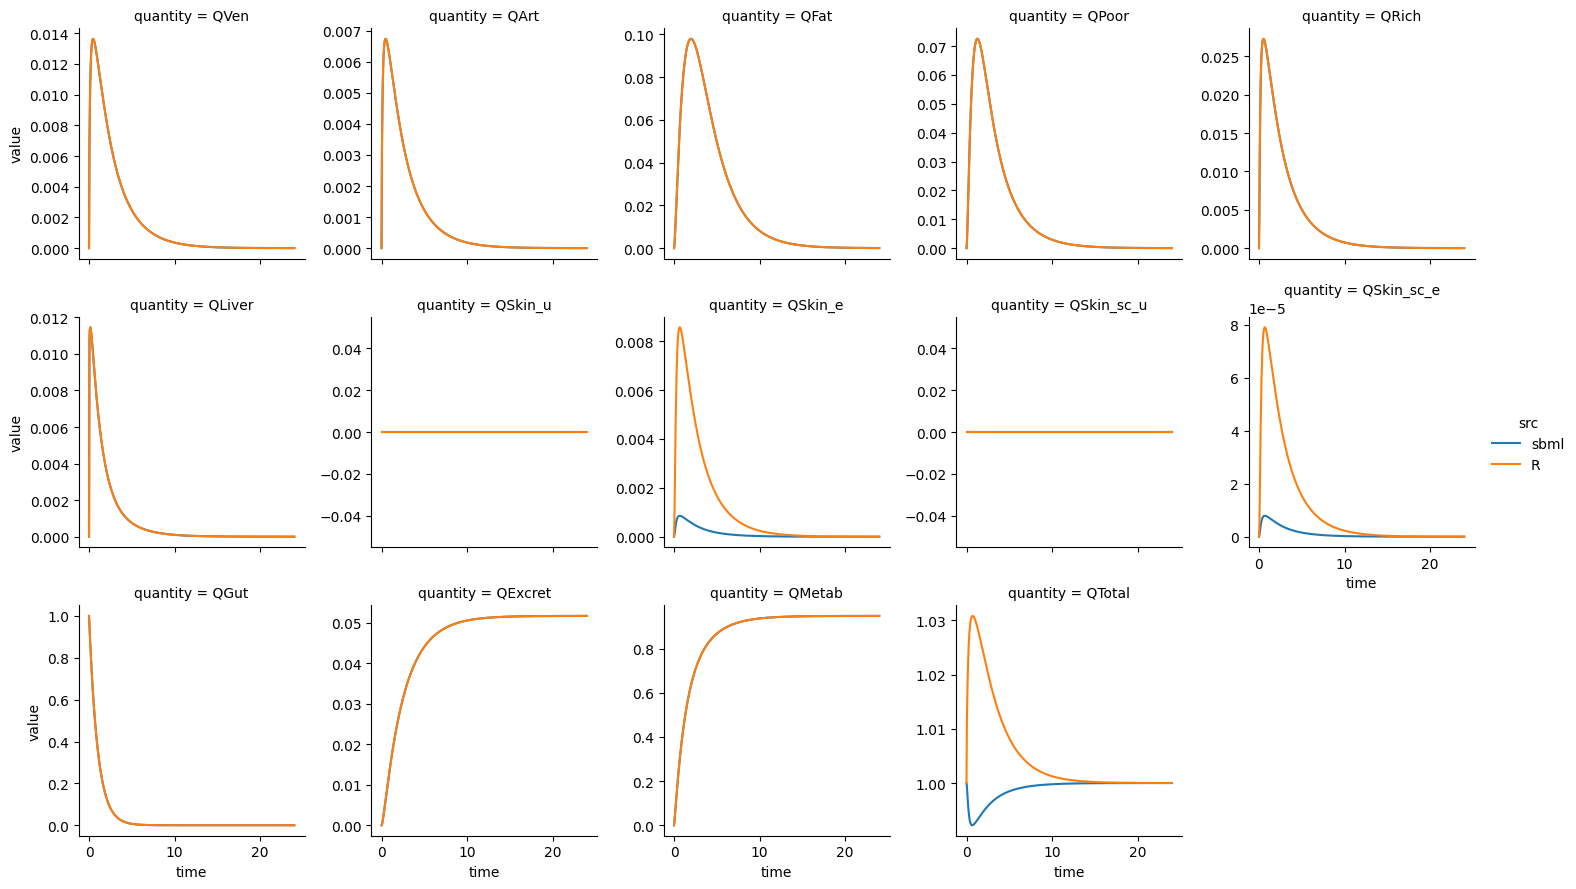

In [379]:
r = te.loada(fn_ant) # Load model with fSA_exposed = 0.1
print(r.VSkin_e)
print(r.VSkin_u)
print(r.getCompartmentVolumes())

r.fSA_exposed = 1
r.QGut = 1

print(r.VSkin_e)
print(r.VSkin_u)
print(r.getCompartmentVolumes()) # Compartment volumes were not updated properly without assignment rule in compartment volumes

compare(r.simulate(0, 24, 500), fn_r='euromix_r_results_MA.csv')



The get_vol_map function which is used to compare results, loads the original antimony file. In this original file, the compartment volumes are the old ones, which explains the incorrect results. Below I demonstrate the 

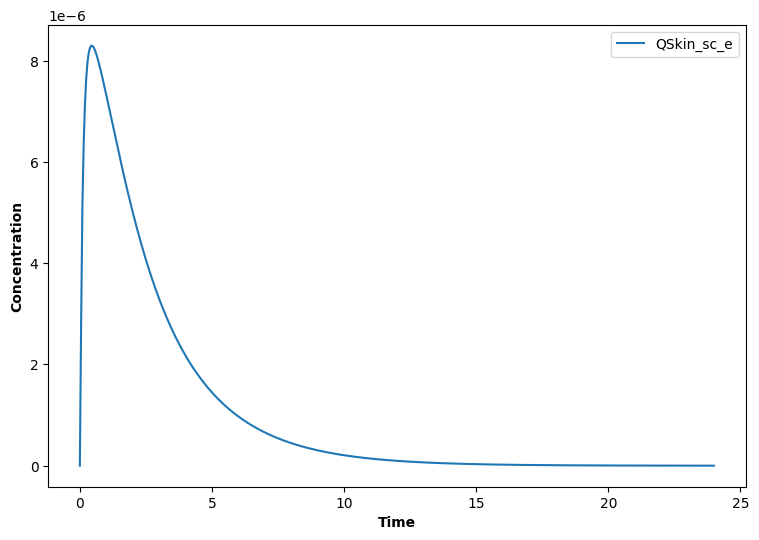

In [387]:
r = te.loada(fn_ant) # Load model with fSA_exposed = 0.1

r.fSA_exposed = 1
r.QGut = 1

p = te.ParameterScan(r)

p.startTime = 0
p.endTime = 24
p.numberOfPoints = 500
p.width = 2
p.xlabel = 'Time'
p.ylabel = 'Concentration'
p.selection = ["QSkin_sc_e"]
p.title = 'Cell'

p.plotArray()

Note that the peak is now at the same spot as the peak of the R results.


# Check parameters update 

In [384]:
r = te.loada(fn_ant) # Load model with fSA_exposed = 1
params1 = (list(zip(r.getGlobalParameterIds(), r.getGlobalParameterValues())))

In [385]:
r = te.loada(fn_ant) # Load model with fSA_exposed = 0.1
r.fSA_exposed = 1
params2 = (list(zip(r.getGlobalParameterIds(), r.getGlobalParameterValues())))

In [386]:
params1 == params2

True

Apparantly, the parameter values are the same. So this means that these parameters may not be used when performing the simulation.

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the sbml simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.

# Michaelis menten kinetics

<Model euromix>


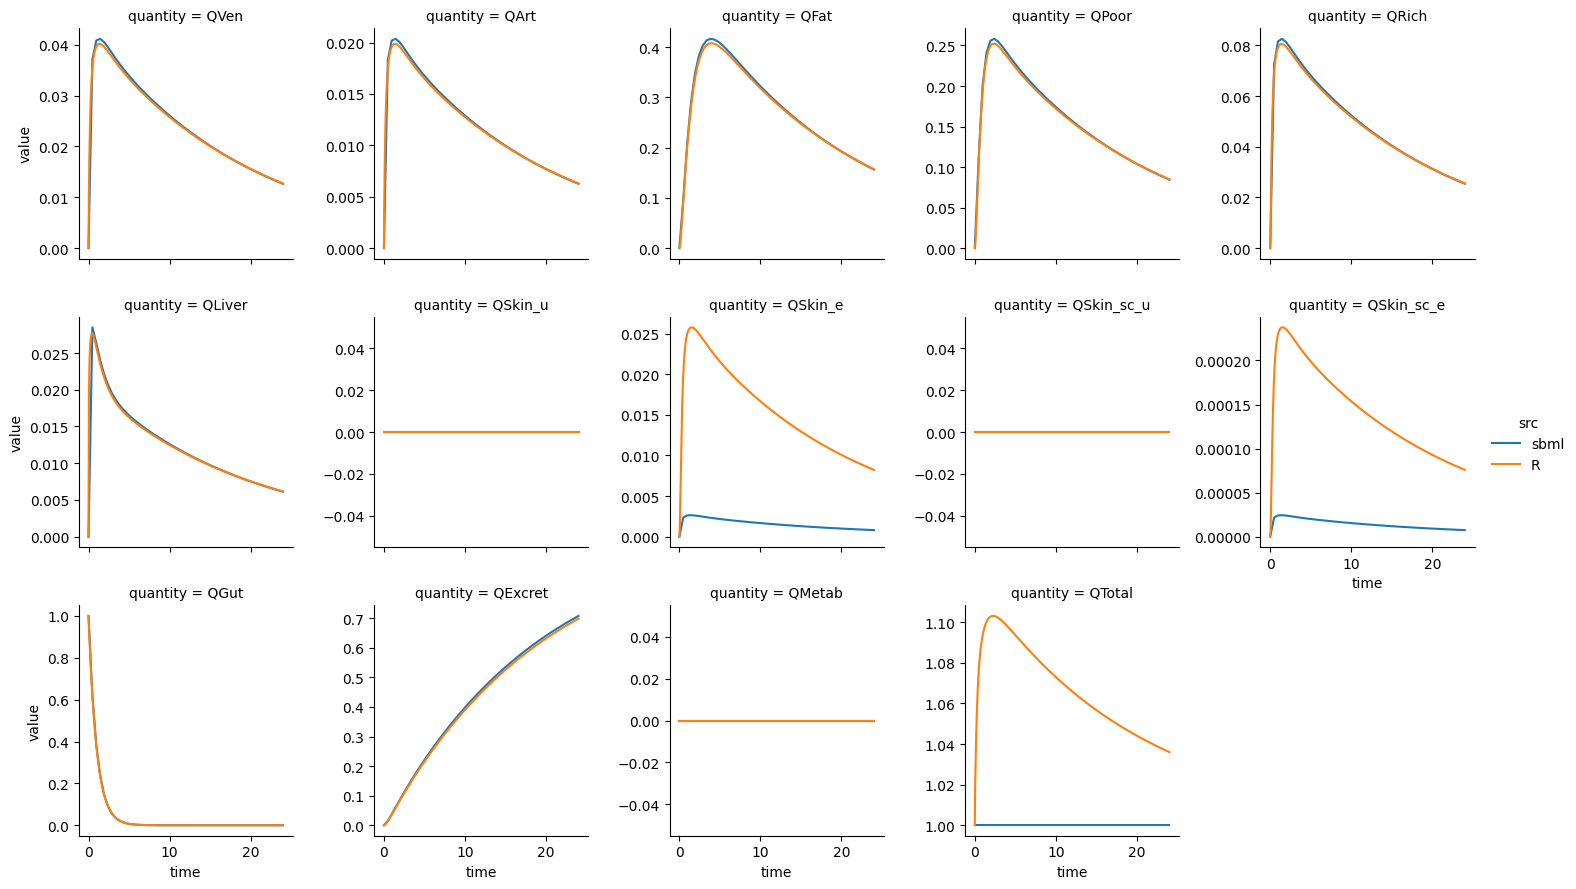

In [16]:
r = te.loada(fn_ant)
r.QGut = 1
r.Michaelis = 1
r.Km = 1
r.fSA_exposed = 1
compare(r.simulate(0, 24), fn_r='euromix_r_results_MM.csv')

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the sbml simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.